# Simple Convolutional Q8 Classification -- 3/14/2017

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers.convolutional import Convolution1D
from keras.optimizers import SGD
from keras.regularizers import l2


import cullpdb_loader

Using TensorFlow backend.


## Constants and Hyperparameters

In [2]:
NUM_RESIDUES = 700  # per protein
RESIDUE_SIZE = 22  # size of one hot vector per residue
NUM_CLASSES = 9  # 8 + 'NoSeq'

LAYER_SIZE = 100  # Number of neurons/nodes at each layer
                  # equivalently, size of output by each convolutional layer
WINDOW_SIZE = 11  # "scope" of convolution (ie 11 total residues)

INPUT_SHAPE = (NUM_RESIDUES, RESIDUE_SIZE)  # see below
OUTPUT_SIZE = NUM_CLASSES  # output matrix holding predictions

LEARNING_RATE = 0.04
EPOCHS = 30  # iterations of training, total dataset covered once each epoch
LOSS='categorical_crossentropy'

SAVE_FILE = "models/conv3dense-3-14"
DATA= "data/cullpdb+profile_6133.npy.gz"

## Load Data
<b>Data:</b><br> _x represents input proteins, _y represents target structure classifications (each as one-hot vectors) <br><br>
<b>Data Shape:</b><br> First dimension represents number of proteins, second number of residues per protein, and third size of residue or structure vector.<br> For example, train_x is shape (5600, 700, 22): it is an <b>m * n * p</b> matrix where there are <b>m</b> proteins (each row), <b>n</b> residues per protein (each column), and <b>p</b> sized vectors to represent a single residue or a single structure (each "slice").

In [3]:
train, validation, test = cullpdb_loader.load_residues_2D(DATA)  # load from my helper file

# train, validation, and test were loaded as tuples of (input, output);
# here we unpack them into separate variables:
train_x, train_y = train
vali_x, vali_y = validation
test_x, test_y = test

# print to verify data was loaded in correct shapes:
print(train_x.shape)
print(train_y.shape)
print(vali_x.shape)
print(vali_y.shape)

Loading protein residues and labels...
Loading file from C:\SANJAY\CS\Projects\sdscbio\data\cullpdb+profile_6133.npy.gz...
File Loaded.
Loaded protein residues and labels.
(5600, 700, 22)
(5600, 700, 9)
(256, 700, 22)
(256, 700, 9)


## Model Architecture
The model is constructed to currently have 3 convolutional layers.<br><br>
Interpretation 1: Each "node" in a convolutional layer is like a fully connected node in a typical feedforward neural network, except instead of receiving from every feature (residue) of the input set, it only receives a local "window" of features.<br><br>
Interpretation 2: A convolutional window "slides" across the input, each time taking the nearest <i>WINDOW_SIZE</i> number of features (residues) as inputs and outputing a single value, where <i>LAYER_SIZE</i> number of values are output.
<br><br>
Finally a "dense", fully connected layer reduces the dimensionality of the data from the previous <i>LAYER_SIZE</i> dimensions to <i>OUTPUT_SIZE</i> dimensions (here 9, 8 for each secondary structure class and 1 for None).

In [4]:
model = Sequential()

# 1st layer
# border_mode indicates how the convolution handles the edges of the input (where the window "sticks out").
# The 'same' setting pads the inputs with zeros on either side.
# Only the first layer requires an input_shape parameter; successive layers infer it from within the model.
model.add(Convolution1D(
        LAYER_SIZE, WINDOW_SIZE, activation='tanh', border_mode='same', input_shape=INPUT_SHAPE))
# 2nd layer
model.add(Convolution1D(
        LAYER_SIZE, WINDOW_SIZE, activation='tanh', border_mode='same'))
# 3rd layer
model.add(Convolution1D(
        LAYER_SIZE, WINDOW_SIZE, activation='tanh', border_mode='same'))

# 4th layer
#model.add(Convolution1D(LAYER_SIZE, WINDOW_SIZE,
#                        activation=Activation('tanh'), border_mode='same'))
# 5th layer
#model.add(Convolution1D(LAYER_SIZE, WINDOW_SIZE, 
#                        activation=Activation('tanh'), border_mode='same'))

# Experiment - Dense final layer
# 'lecun_uniform' indicates that the weights should be initialized to small random values in a certain normal distribution.
model.add(Dense(OUTPUT_SIZE, init='lecun_uniform', activation='softmax'))


### Compile the model given a loss function and learning rate (specified above)

In [5]:
# optimizer= takes either string or optimizer object
model.compile(loss=LOSS, optimizer=SGD(lr=LEARNING_RATE), metrics=['accuracy'])

### Train the model on training data against target training labels, showing accuracy on validation data each epoch

In [6]:
# verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
hist = model.fit(train_x, train_y, nb_epoch=EPOCHS, 
          validation_data=(vali_x, vali_y), shuffle=False, verbose=2)
print("Done training")

Train on 5600 samples, validate on 256 samples
Epoch 1/30
99s - loss: 0.6970 - acc: 0.7773 - val_loss: 0.4939 - val_acc: 0.8040
Epoch 2/30
104s - loss: 0.4953 - acc: 0.8044 - val_loss: 0.4882 - val_acc: 0.8042
Epoch 3/30
101s - loss: 0.4919 - acc: 0.8049 - val_loss: 0.4860 - val_acc: 0.8050
Epoch 4/30
102s - loss: 0.4896 - acc: 0.8054 - val_loss: 0.4837 - val_acc: 0.8054
Epoch 5/30
106s - loss: 0.4867 - acc: 0.8062 - val_loss: 0.4804 - val_acc: 0.8058
Epoch 6/30
102s - loss: 0.4826 - acc: 0.8072 - val_loss: 0.4758 - val_acc: 0.8072
Epoch 7/30
106s - loss: 0.4769 - acc: 0.8098 - val_loss: 0.4698 - val_acc: 0.8142
Epoch 8/30
108s - loss: 0.4703 - acc: 0.8164 - val_loss: 0.4637 - val_acc: 0.8206
Epoch 9/30
108s - loss: 0.4644 - acc: 0.8222 - val_loss: 0.4589 - val_acc: 0.8238
Epoch 10/30
105s - loss: 0.4600 - acc: 0.8253 - val_loss: 0.4556 - val_acc: 0.8254
Epoch 11/30
103s - loss: 0.4570 - acc: 0.8268 - val_loss: 0.4531 - val_acc: 0.8267
Epoch 12/30
103s - loss: 0.4546 - acc: 0.8279 - va

In [7]:
model.save(SAVE_FILE)

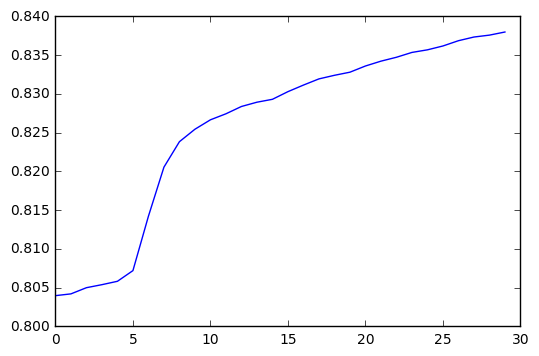

In [8]:
validation_loss = list(hist.history.values())[0]
plt.plot(range(EPOCHS), validation_loss)

## RESULTS (so far)

*UNPLUGGED* 1 conv layer (100), dense layer, 10 epochs, lr = 0.01 -- 35s/epoch, validation loss = 0.50, val acc = 0.80 (still increasing by end of training)
<br>
*UNPLUGGED* 3 conv layer (100), dense layer, 10 epochs, lr = 0.01 -- 185s/epoch, val loss =  0.487, val acc = 0.804 (still increasing by end of training)
<br>
3 conv layer (100), dense layer, 30 epochs, lr = 0.04 -- 105s/epoch, val loss = 0.424, val acc = 0.838 (still increasing by end of training)

(*laptop unplugged => reduced computational power, longer training)